# Synopsis
By: Kaushalya Samarasekera, November 2022

In this notebook I first perform an exploratory data analysis on the *[Short-term electricity load forecasting (Panama case study)](https://data.mendeley.com/datasets/byx7sztj59/1)* dataset to survey the data quality and distribution of its target variables.

Then the data is passed through a couple of Ensemble methods to derive the best performing model. Firstly a Random Forest regressor is used to form a benchmark followed by a XGBoost regressor in search for a model with higher accuracy. During this process a number of model parameters are tuned and evaluated repetitively to minimize the prediction errors.

Finally, the best performing model is exported to a bentoml model to use in `predict.py` to serve through a web api.

# Dataset

The [source dataset](https://data.mendeley.com/datasets/byx7sztj59/1) consists of 16 features, 1 target variable (i.e. `nat_demand`) and 48,048 observations. A brief description of each variable is shown in the following table.
<br>

| Variable   | Description                                                                                                                                                          |
|------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| nat_demand | **Target Variable**. National electricity demand (aka load).<br>This is the actual electricity load as captured by the grid operator after the fact (post-dispatch). |
| datetime   | Date-time  corresponding to Panama timezone UTC -0500.                                                                                                               |
| T2M_toc    | Temperature in Celsius at 2 metres in Tocumen, Panama city.                                                                                                          |
| QV2M_toc   | Relative humidity and a percentage (%)  at 2 metres in Tocumen, Panama city.                                                                                         |
| TQL_toc    | Liquid precipitation in litres per square metre (l/m<sup>2</sup>) in Tocumen, Panama city.                                                                           |
| W2M_toc    | Wind speed in metres per second (m/s) at 2 metres in Tocumen, Panama city.                                                                                           |
| T2M_san    | Temperature in Celsius at 2 metres in Santiago city.                                                                                                                 |
| QV2M_san   | Relative humidity and a percentage (%)  at 2 metres in Santiago city.                                                                                                |
| TQL_san    | Liquid precipitation in litres per square metre (l/m<sup>2</sup>) in Santiago city.                                                                                  |
| W2M_san    | Wind speed in metres per second (m/s) at 2 metres in Santiago city.                                                                                                  |
| T2M_dav    | Temperature in Celsius at 2 metres in David city.                                                                                                                    |
| QV2M_dav   | Relative humidity and a percentage (%)  at 2 metres in David city.                                                                                                   |
| TQL_dav    | Liquid precipitation in litres per square metre (l/m<sup>2</sup>) in David city.                                                                                     |
| W2M_dav    | Wind speed in metres per second (m/s) at 2 metres in David city.                                                                                                     |
| Holiday_ID | Unique identification number (an integer) for the holiday.                                                                                                           |
| holiday    | Indicates if the day is a holiday or not. 1 if holiday, 0 otherwise.                                                                                                 |
| school     | Indicates if the day is a school day or not. 1 if a school day, 0 otherwise.                                                                                         |

Apart from `nat_demand` and `datetime`, the rest of the features can be divided into two categories; weather data and holiday data.
Weather data - Contains four weather data variables (wild, humidity, precipitation and wind speed) from 3 cities in Panama; Tocumen, Santiago and David.
Holiday data - Three variables (holiday_id, holiday and school), indicating whether the workforce of the nation and/or the academic institutions were operating or not.
<br/>
<img src="assets/three_cities_v2.png" alt="The weather data is from these 3 cities - Tocumen, Santiago and David" />

Under the Exploratory Data Analysis (EDA) section I will be inspecting each variable more closely.

Later in the notebook I will be dissecting, adding and removing certain variables based on the EDA, so the dataset can work better with the learning algorithms that I'm employing.

# Imports

In [48]:
import calendar

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import json

from shared_func import train_gb_model

# Exploratory Data Analysis (EDA)

In [49]:
# loading the complete dataset
data_file = 'data/continuous_dataset.csv'
df = pd.read_csv(data_file)

In [50]:
# This dataset contains the feature variables and dependent variable datetime.
df[:100]

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2015-01-07 00:00:00,979.6728,24.899164,0.016859,0.011879,20.375056,22.680414,0.016531,0.016052,9.519345,21.953851,0.015768,0.098938,6.345989,0,0,0
96,2015-01-07 01:00:00,940.4568,24.863245,0.016943,0.015156,20.156554,22.425745,0.016386,0.015404,10.078217,21.761682,0.015573,0.100281,6.593827,0,0,0
97,2015-01-07 02:00:00,908.5931,24.865564,0.017057,0.018219,20.108580,22.248376,0.016226,0.012043,10.661059,21.568689,0.015363,0.100769,6.843872,0,0,0
98,2015-01-07 03:00:00,886.4675,24.900903,0.017172,0.018593,20.347526,22.057153,0.016035,0.007059,11.029632,21.400903,0.015165,0.102234,7.152504,0,0,0


In [51]:
df.describe()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


According to the *describe* output, this is a clean dataset. There are no data corrections required. Below I'm performing some verifications to confirm this.

In [52]:
# Making columns lower case for better readability.
df.columns = df.columns.str.lower()
df.columns

Index(['datetime', 'nat_demand', 't2m_toc', 'qv2m_toc', 'tql_toc', 'w2m_toc',
       't2m_san', 'qv2m_san', 'tql_san', 'w2m_san', 't2m_dav', 'qv2m_dav',
       'tql_dav', 'w2m_dav', 'holiday_id', 'holiday', 'school'],
      dtype='object')

In [53]:
# Checking if there are missing values in any of the variables. None found.
df.isna().sum()

datetime      0
nat_demand    0
t2m_toc       0
qv2m_toc      0
tql_toc       0
w2m_toc       0
t2m_san       0
qv2m_san      0
tql_san       0
w2m_san       0
t2m_dav       0
qv2m_dav      0
tql_dav       0
w2m_dav       0
holiday_id    0
holiday       0
school        0
dtype: int64

In [54]:
# Check the data types of the variables. Looks like datatime is a string and all other variables are numeric (int or float).
df.dtypes

datetime       object
nat_demand    float64
t2m_toc       float64
qv2m_toc      float64
tql_toc       float64
w2m_toc       float64
t2m_san       float64
qv2m_san      float64
tql_san       float64
w2m_san       float64
t2m_dav       float64
qv2m_dav      float64
tql_dav       float64
w2m_dav       float64
holiday_id      int64
holiday         int64
school          int64
dtype: object

In [55]:
# Checking if variable `school` has non-boolean values
df.school.value_counts()

1    34969
0    13079
Name: school, dtype: int64

In [56]:
# Checking if variable `holiday` has non-boolean values
df.holiday.value_counts()

0    45024
1     3024
Name: holiday, dtype: int64

In [57]:
# Checking if 0's in `holiday_id` matches the number of holidays based on `holiday`.
assert df.holiday_id.value_counts()[0] == df.holiday.value_counts()[0]

As observed above, `datetime` is a string variable. Instead of keeping it in string form, it's needful to split it in to more granular components for the following reasons:
* For regression model training the input features need to be in numerical form. Splitting the datetime values to individual components meets this prerequisite.
* Having this variable converted to python datetime will work better when comes to date-time based plotting.
* Data exploration will be easier as it allows to employ date/time functions for data filtering and manipulation.

So I'm first converting the string representation of the datetime to a python `datetime` object and then split it to year, month, day and hour components. Each component is then added back to the dataframe as a new variable. Also removed the variable that contains the full datetime value and made it the index of the dataframe. This will help me to perform index based filtering and plotting later, if required.

Note that this increases the number of features to 19 (from 16).

In [58]:
# Setting the index of the dataframe to be the datetime. The type of the new index is python's datetime, derived by converting the values from `df.datetime`.
new_index = pd.to_datetime(df.datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Checking if there are datetime conversion errors.
assert new_index.isnull().sum() == 0

# Assigning new index to the dataframe
df.index = new_index

In [59]:
# Splitting year, month, day and hour to new variables
df['dt_year'] = df.index.year
df['dt_month'] = df.index.month
df['dt_day'] = df.index.day
df['dt_hour'] = df.index.hour

# Delete feature 'datetime' from the dataframe as it's now superseded by the individual date and time features.
del df['datetime']

# No need to separate minute and second values as they are always 0. Verified and confirmed.
# df['dt_minute'] = df.datetime.dt.minute
# df['dt_second'] = df.datetime.dt.second

In [60]:
# Look at first 5 of 10000th record for a visual check to confirm that they've been split correctly (from a semantic viewpoint).
# Programmatic check was done earlier by checking for conversion errors. See above.
df.filter(regex='dt.*')[::10000].head()

,dt_year,dt_month,dt_day,dt_hour
datetime,,,,
2015-01-03 01:00:00,2015,1,3,1
2016-02-23 17:00:00,2016,2,23,17
2017-04-15 09:00:00,2017,4,15,9
2018-06-06 01:00:00,2018,6,6,1
2019-07-27 17:00:00,2019,7,27,17


--------------------------------------

In [61]:
df.filter(regex='dt.*').describe()

,dt_year,dt_month,dt_day,dt_hour
count,48048.000000,48048.000000,48048.000000,48048.000000
mean,2017.268336,6.255349,15.712288,11.500000
std,1.596256,3.440947,8.779474,6.922259
min,2015.000000,1.000000,1.000000,0.000000
25%,2016.000000,3.000000,8.000000,5.750000
50%,2017.000000,6.000000,16.000000,11.500000
75%,2019.000000,9.000000,23.000000,17.250000
max,2020.000000,12.000000,31.000000,23.000000


The dataset contains records for 6 years, from 2015 and 2020 inclusive. Only the first 6 months' data is available for 2020.

<AxesSubplot: title={'center': 'Time period of the observations'}, xlabel='Year', ylabel='Month'>

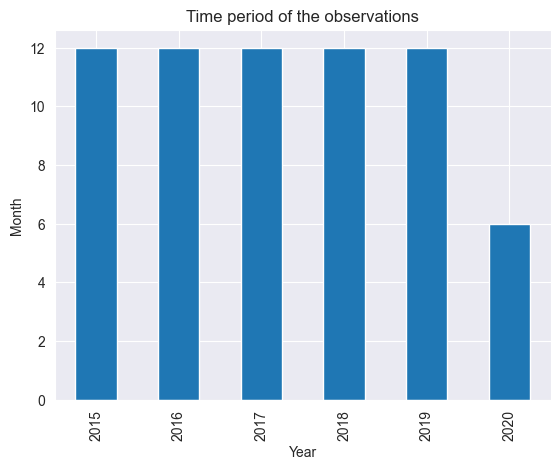

In [62]:
df_nmonths = df.filter(['dt_year', 'dt_month']).groupby('dt_year').nunique()
df_nmonths.plot.bar(title='Time period of the observations', xlabel='Year', ylabel='Month', legend=False)

In [63]:
# Checking what are the months from 2020 that I have observations for.
[calendar.month_abbr[i] for i in list(df[df.dt_year == 2020].dt_month.unique())]

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']

--------------------------------------

Here is the distribution of the target variable `nat_demand` (short for National Electricity Demand). The target variables shows a normal/Gaussian distribution. I plotted this solely for data exploratory purposes. It's important to note that having a normal distribution is [not a must](https://data.library.virginia.edu/normality-assumption/#:~:text=No%2C%20you%20don't%20have,or%20an%20outcome%20(DV).) for regression based predictions. What's important to ensure is that the *prediction error* is normally distributed. A plot for the prediction error distribution can be found in the section where the best performing model is derived (towards the end of the notebook).

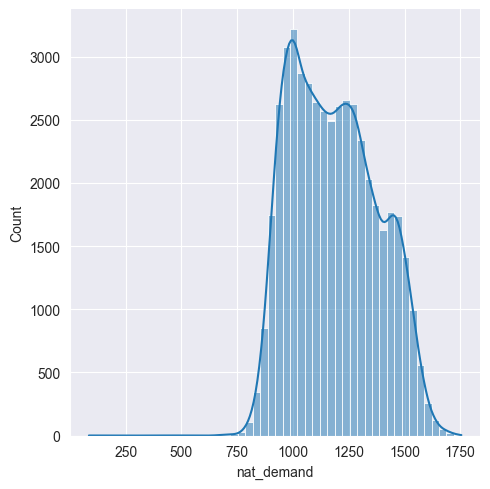

In [64]:
sns.displot(df.nat_demand, bins=50, kde=True)

<AxesSubplot: xlabel='nat_demand', ylabel='Count'>

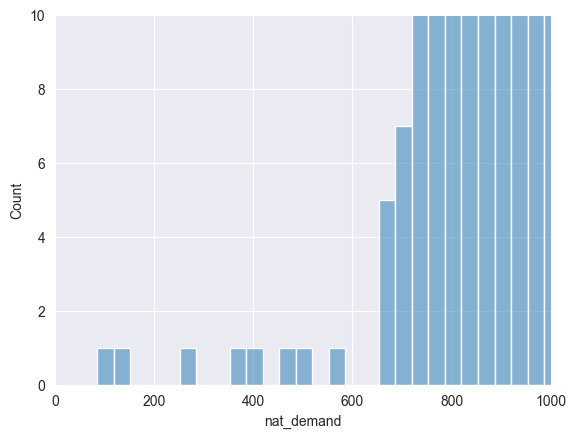

In [65]:
# Focusing on the outliers on the left for a closer look. This is the reason the distribution is not centred.
plt.xlim(0, 1000)
plt.ylim(0, 10)
sns.histplot(df.nat_demand, bins=50, alpha=0.5)

In [66]:
# Looks like there are 8 very low demands. This is only a 0.017% of the total records.
# Without these outliers the national demand values are near 'normally' distributed with no long tails.
round(df.nat_demand[df.nat_demand < 600].size / len(df.nat_demand) * 100, 3)

0.017

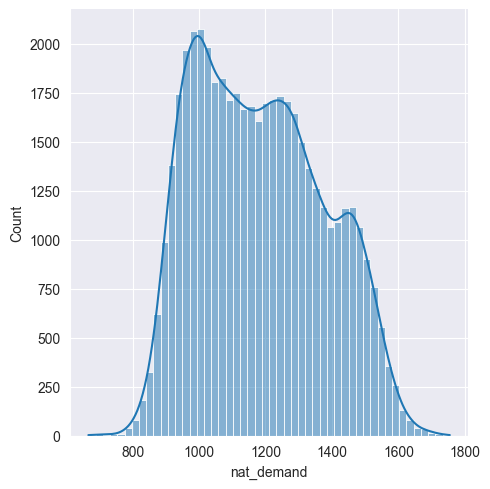

In [67]:
sns.displot(df.nat_demand[df.nat_demand > 600], bins=50, kde=True)

In [68]:
# Splitting the dataset to 80%, 20%, 20% for training, validation, and testing, respectively.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
f'train:val:test split is {(len(df_train), len(df_val), len(df_test))}'

'train:val:test split is (28828, 9610, 9610)'

In [69]:
# Also create a copy of the complete dataframe with order intact to plot actual vs forecast based on the final model.
df_full = df.copy()
f'complete dataset is {len(df_full)}'

'complete dataset is 48048'

In [70]:
# Defining the target arrays for each feature datasets
y_full_train = df_full_train.nat_demand
y_train = df_train.nat_demand
y_val = df_val.nat_demand
y_test = df_test.nat_demand
y_full = df_full.nat_demand

In [71]:
# Removing unwanted variables
for c in ['nat_demand']:
    del df_full_train[c]
    del df_train[c]
    del df_val[c]
    del df_test[c]
    del df_full[c]

In [72]:
# Vectorize the features
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

features = dv.get_feature_names_out()

# Initialize dmatrix objects to use later in xgboosting
dm_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dm_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)
dm_test = xgb.DMatrix(X_test, label=y_test, feature_names=features)

## Feature Importance

Here I'm evaluating what are the important features out of the feature set and assess if there are any features that can be removed without compromising model's performance. I'm using two methods for the evaluation; F-statistic value and Mutual Information.

### F-statistic score
I'm using scikit-learn's `SelectKBest` and `f_regression` to calculate the F-statistic for all the features and then visualize them in a bar plot.

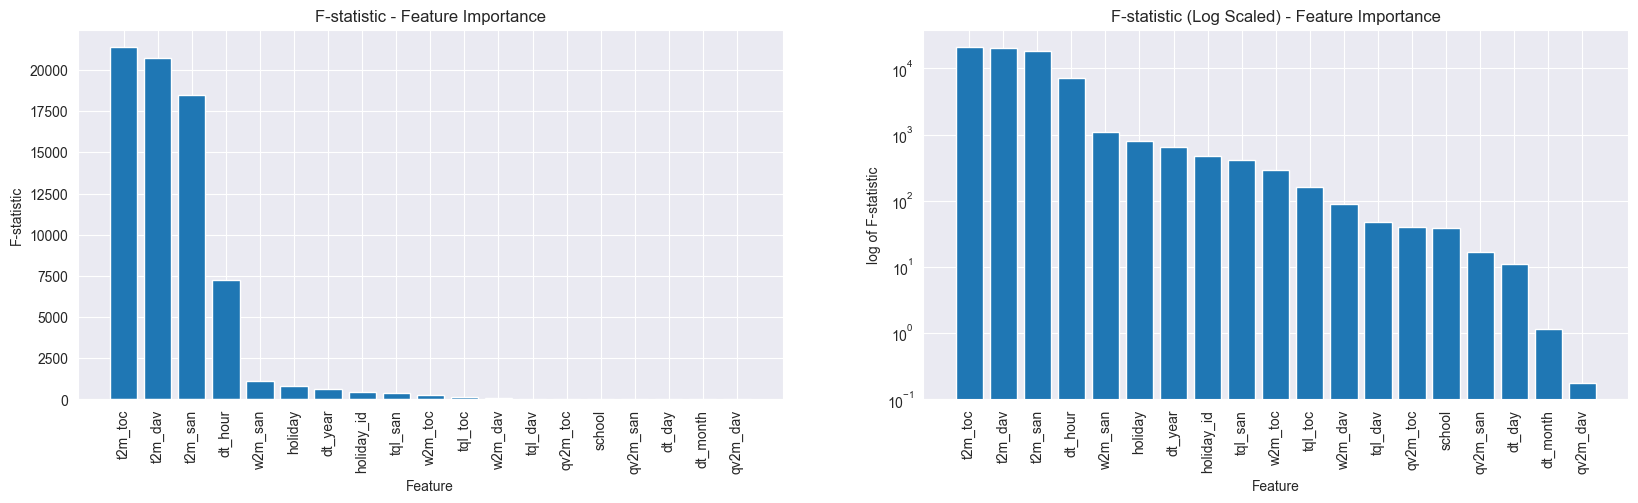

In [73]:
selector_fstats = SelectKBest(score_func=f_regression, k='all')
selector_fstats.fit(df_train, y_train)
df_fstats = pd.DataFrame({'score': selector_fstats.scores_})
df_fstats.index = selector_fstats.get_feature_names_out()
df_fstats = df_fstats.sort_values(by='score', ascending=False)
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(20)

axs[0].set_title('F-statistic - Feature Importance')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('F-statistic')
axs[0].bar(df_fstats.index, df_fstats.score)
for tick in axs[0].get_xticklabels(): tick.set_rotation(90)

axs[1].set_title('F-statistic (Log Scaled) - Feature Importance')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('log of F-statistic')
axs[1].bar(df_fstats.index, df_fstats.score, log=True)
for tick in axs[1].get_xticklabels(): tick.set_rotation(90)

This highlights the temperature from all three cities has the highest relation to the national electricity demand, followed by the hour of the day. It's interesting to see the wind speed data from Santiago has the next highest influence, though it's relatively low compared to the first four features. Data about the holidays shows slightly lower yet similar influence on the target variable.

If I train Benchmark 1 Model (from the following section) with only the top 11 features as per the figure on the left (by excluding `w2m_dav`,`tql_dav`, `qv2m_toc`, `school`, `qv2m_san`, , `dt_day`, `dt_month`, `qv2m_dav`), the Root Mean Squared Error (RMSE) of the model increases to 88.698232, which is a 10MWh increase in mean prediction error.
My observation here is even though the unscaled plot (left figure) shows some features with very low importance, still they have a high influence on minimising the prediction errors. Because the size of the total feature set of this dataset is small.

The scaled plot on the right shows the importance of each feature more clearly.

### Mutual Information

To calculate the Mutual Information (MI) score fo rthe features I exmpoy scikit-learn's `SelectKBest` and `mutual_info_regression`. Similar to what was done in the previous section, I plot the resulting scores on a bar chart for comparison.


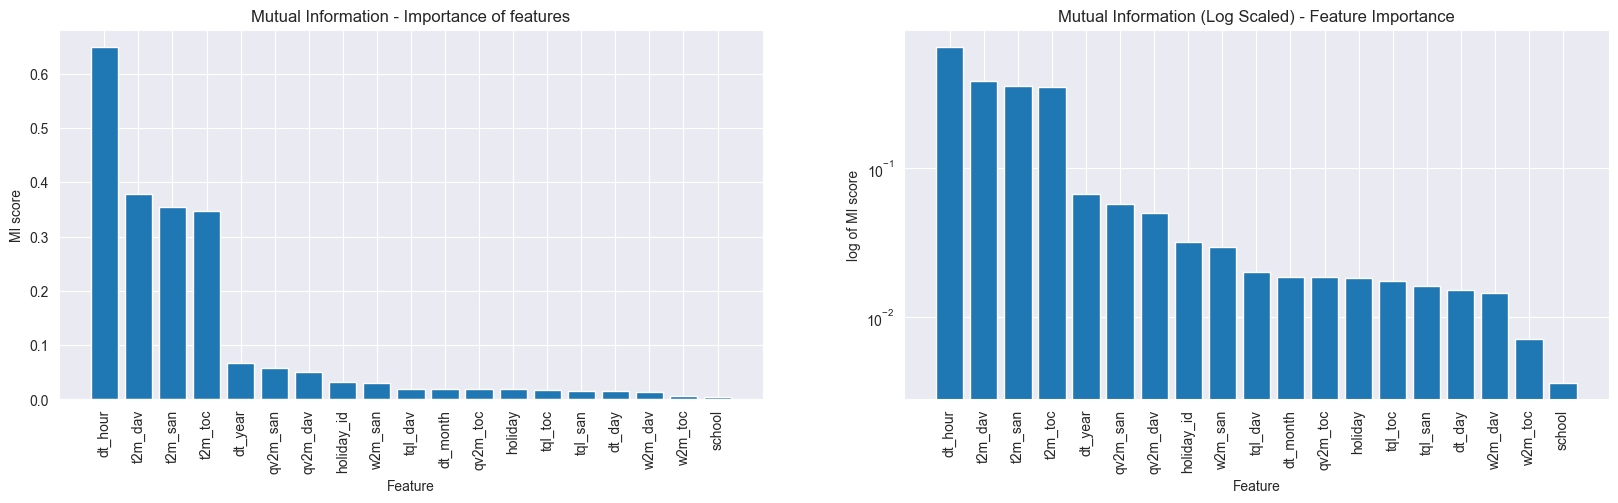

In [74]:
selector_mutinfo = SelectKBest(score_func=mutual_info_regression, k='all')
selector_mutinfo.fit(df_train, y_train)

df_mutinfo = pd.DataFrame({'score': selector_mutinfo.scores_})
df_mutinfo.index = selector_mutinfo.get_feature_names_out()
df_mutinfo = df_mutinfo.sort_values(by='score', ascending=False)
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(20)

axs[0].set_title('Mutual Information - Importance of features')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('MI score')
axs[0].bar(df_mutinfo.index, df_mutinfo.score)
for tick in axs[0].get_xticklabels(): tick.set_rotation(90)

axs[1].set_title('Mutual Information (Log Scaled) - Feature Importance')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('log of MI score')
axs[1].bar(df_mutinfo.index, df_mutinfo.score, log=True)
for tick in axs[1].get_xticklabels(): tick.set_rotation(90)

The MI scores reconfirm that `dt_hour` and `t2m_*` (temperature) features are the most important out of the complete feature set. Feature `dt_hour` has taken a higher score than the temperature features, which is the opposite of what I saw with F-statistics.

Score of `school` is the lowest, yet it's greater than 0, which means it's not independent to the target variable.

Based on the above analysis I conclude that each of the 19 feature sare significant enough to be present in the feature matrix for the model training. In the next half of the notebook I'll be using these features to train different models and evaluate them to find one with minimal prediction errors.

# Random Forest

In this section I'm training a Random Forest Regressor by tuning 3 of its parameters, namely `n_estimators`, `max_depth` and `min_samples_leaf`, to derive the best (lowest) RMSE score. The resulting RMSE will then be set as the benchmark. Once the benchmark is set, an XGBoost Regressor will be trained and evaluated to see if I can achieve a model with a better (lower) RMSE.

### Benchmark 1
Training a Random Forest model and measuring its performance with its defaults for the parameters.

In [118]:
rf = RandomForestRegressor(random_state=1,
                           n_jobs=-1)
model = rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

<AxesSubplot: ylabel='Feature'>

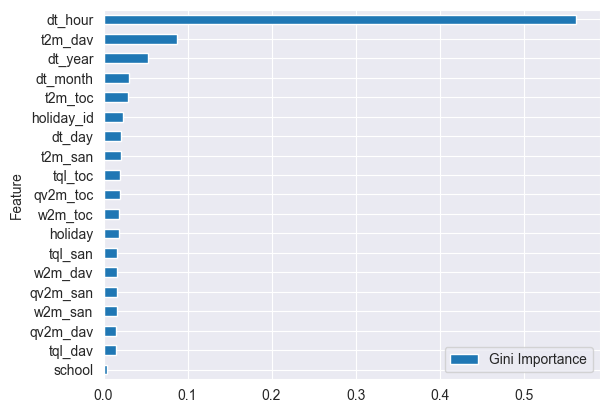

In [119]:
# Let's plot the feature importance (aka Gini importance) that was evaluated and used by the learning algorithm.
ft_imp = list(zip(rf.feature_importances_, dv.get_feature_names_out()))
df_ft_imp = pd.DataFrame(ft_imp, columns=['Gini Importance', 'Feature']).sort_values(by='Gini Importance')
df_ft_imp.plot.barh('Feature')

#### Performance

In [120]:
rf_performance = [('rmse', np.sqrt(mean_squared_error(y_val, y_val_pred))),
                  ('mae', mean_absolute_error(y_val, y_val_pred))]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,78.025756
1,mae,53.758384


### Benchmark 2
For this benchmark I would like to tune model parameters `n_estimators`, `max_depth` and `min_samples_leaf` in search for a model with lower RMSE.

#### Tune `n_estimators` and `max_depth`

In [ ]:
# Finding the optimal max_depth and n_estimators
scores = []
for d in tqdm([20, 25, 30, 35, 40, 45, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, d, rmse, mae))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [122]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse', 'mae'])

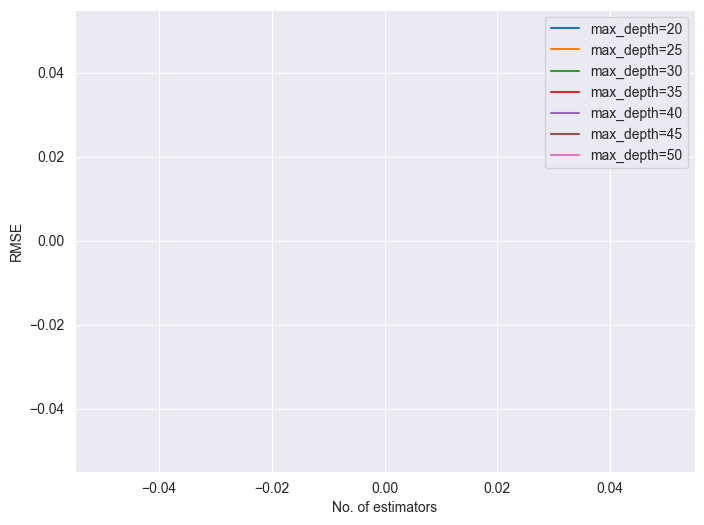

In [123]:
plt.figure(figsize=(8, 6))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for d in [20, 25, 30, 35, 40, 45, 50]:
    plt.plot(df_scores[df_scores.max_depth == d].n_estimators,
             df_scores[df_scores.max_depth == d].rmse,
             label=f'max_depth={d}')
plt.legend()

#### Tune `min_samples_leaf`

In [81]:
# Based on the above graph, optimal max_depth is 30.
max_depth = 30

# Finding the optimal min_samples_leaf
scores = []
for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 20)):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=max_depth,
                                   min_samples_leaf=s,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_val_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        mae = mean_absolute_error(y_val, y_val_pred)
        scores.append((n, s, rmse, mae))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'min_samples_leaf', 'rmse', 'mae'])
df_scores

,n_estimators,min_samples_leaf,rmse,mae
0,10,1,82.749170,56.151398
1,30,1,79.647569,54.457571
2,50,1,78.591844,53.994418
3,70,1,78.081145,53.686325
4,90,1,77.956769,53.682695
5,110,1,77.865872,53.710752
6,130,1,77.847921,53.699541
7,150,1,77.763661,53.670636
8,170,1,77.789606,53.669684
9,190,1,77.753469,53.663693


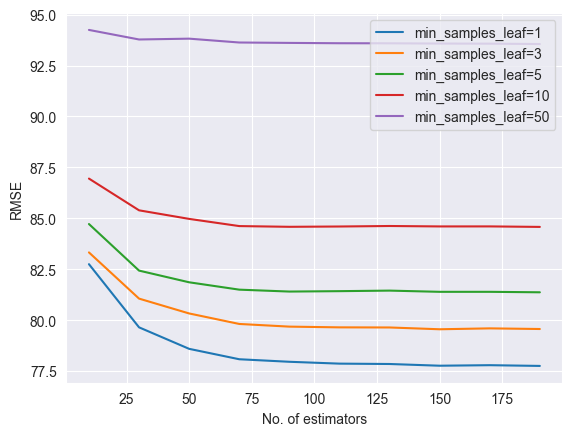

In [83]:
# plt.figure(figsize=(10, 8))
plt.xlabel('No. of estimators')
plt.ylabel('RMSE')
for s in [1, 3, 5, 10, 50]:
    plt.plot(df_scores[df_scores.min_samples_leaf == s].n_estimators,
             df_scores[df_scores.min_samples_leaf == s].rmse,
             label=f'min_samples_leaf={s}')
plt.legend()

In [84]:
n_estimators = 150
max_depth = 30
min_samples_leaf = 1

rf = RandomForestRegressor(n_estimators=n_estimators,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)

#### Feature importance (Gini)

<BarContainer object of 19 artists>

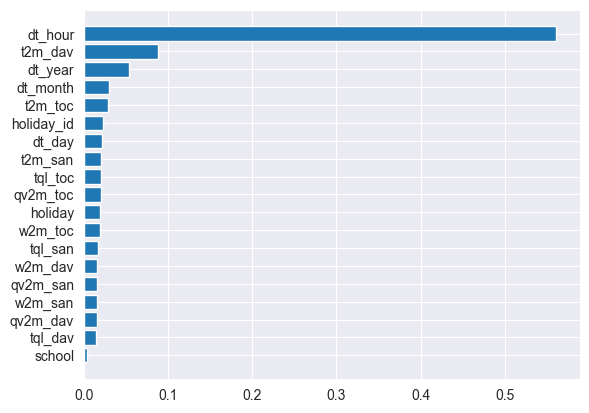

In [85]:
ft_imp = list(zip(rf.feature_importances_, dv.get_feature_names_out()))
df_ft_imp = pd.DataFrame(ft_imp, columns=['score', 'feature']).sort_values(by='score', ascending=True)
plt.barh(df_ft_imp.feature, df_ft_imp.score)

#### Performance

In [86]:
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)

rf_performance = [('rmse', rmse),
                  ('mae', mae)]
pd.DataFrame(rf_performance, columns=['metric', 'score'])

,metric,score
0,rmse,77.763661
1,mae,53.670636


**Result:**
Benchmark 2 results is slightly better than Benchmark 1. Therefore, Benchmark 2 will be used as the benchmark for the model performance and will be used for comparison when measuring performance of the gradient boosting models in the next section.

# XGBoost

### Tune `eta`

In [87]:
scores = pd.DataFrame()
for eta in tqdm([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 1.0]):
    key = f'eta={eta}'
    _, df_scores = train_gb_model(dm_train,
                                  eta=eta,
                                  num_boost_round=201,
                                  watchlist=[(dm_train, 'train'), (dm_val, 'val')])
    scores = pd.concat([scores, df_scores])

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
scores.sort_values(by='val_rmse', ascending=True).reset_index().iloc[::200]

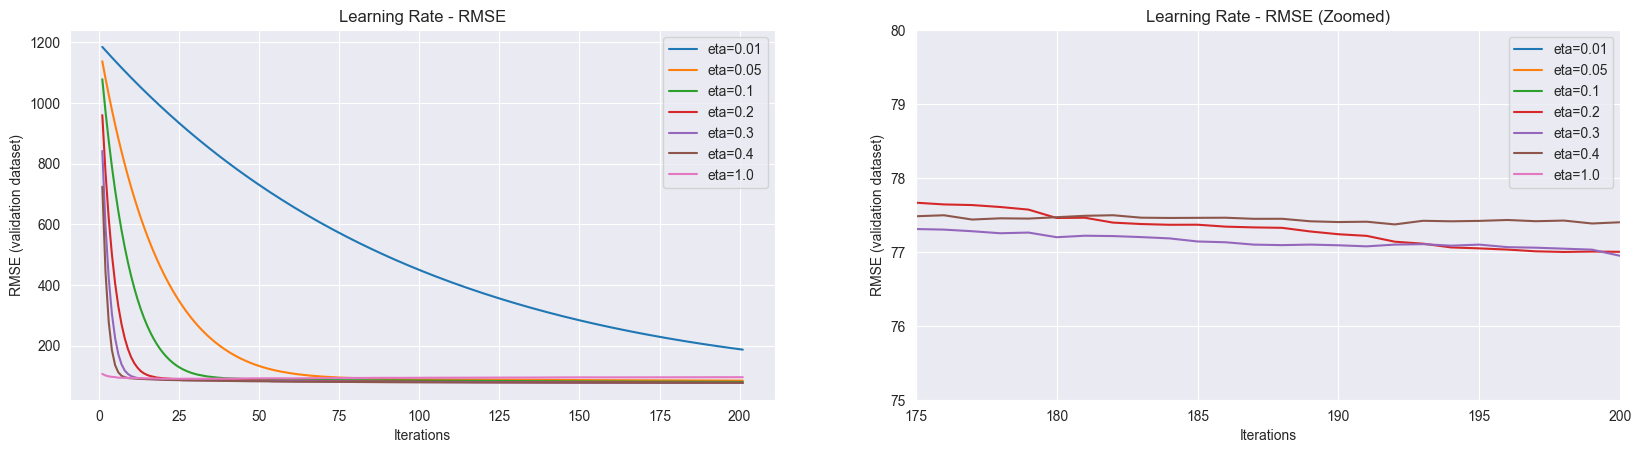

In [89]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Learning Rate - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[0].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[0].legend()

axs[1].set_title('Learning Rate - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([75, 80])
gs = scores.groupby('eta')
gs.get_group(1.00)
gs.groups.values()
for eta in gs.groups.keys():
    df = gs.get_group(eta)
    axs[1].plot(df.iter, df.val_rmse, label=f'eta={eta}')
    axs[1].legend()

In [90]:
# Base on the above analysis, eta=0.3 gives the best performance as the learning rate.
chosen_eta = 0.3

### Tune `max_depth`

In [91]:
scores = {}
for max_depth in [3, 4, 6, 10, 14, 18]:
    key = f'max_depth={max_depth}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=max_depth,
                                    num_boost_round=201,
                                    watchlist=[(dm_train, 'train'), (dm_val, 'val')])

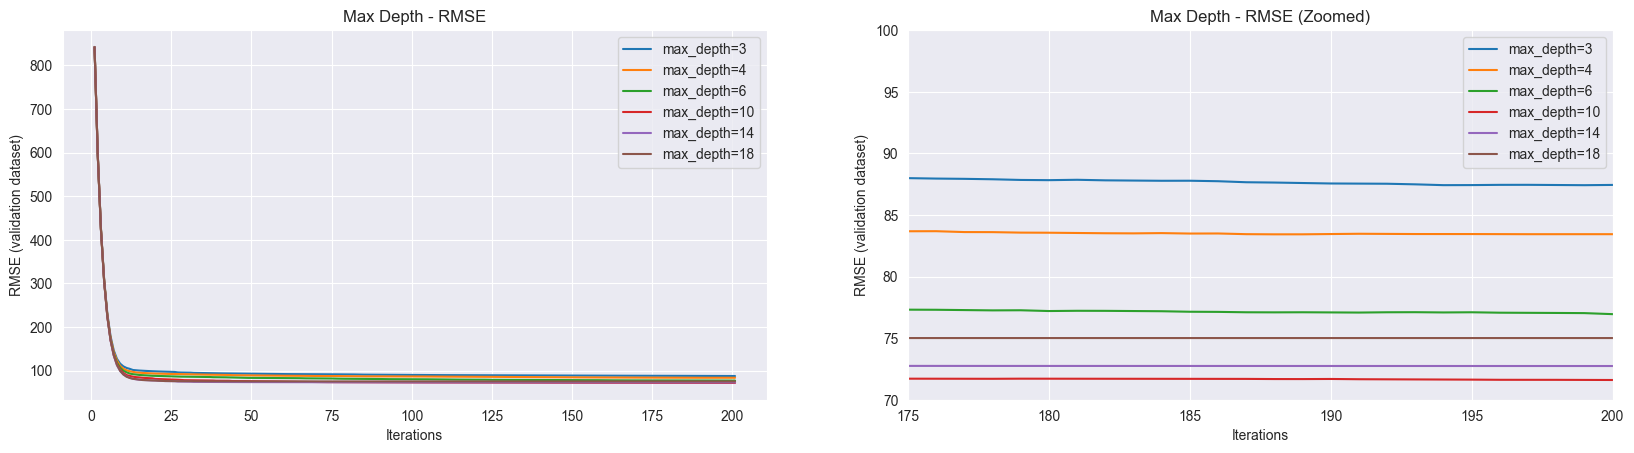

In [92]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Max Depth - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for key, df_scores in scores.items():
    axs[0].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[0].legend()

axs[1].set_title('Max Depth - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 100])
for key, df_scores in scores.items():
    axs[1].plot(df_scores.iter, df_scores.val_rmse, label=key)
    axs[1].legend()

In [93]:
# The above analysis shows max_depth=10 gies the best performance.
chosen_max_depth = 10

### Tune `min_child_weight`

In [94]:
scores = {}
for min_child_weight in [1, 10, 30, 40]:
    key = f'min_child_weight={min_child_weight}'
    _, scores[key] = train_gb_model(dm_train,
                                    eta=chosen_eta,
                                    max_depth=chosen_max_depth,
                                    min_child_weight=min_child_weight,
                                    num_boost_round=201,
                                    watchlist=[(dm_train, 'train'), (dm_val, 'val')])

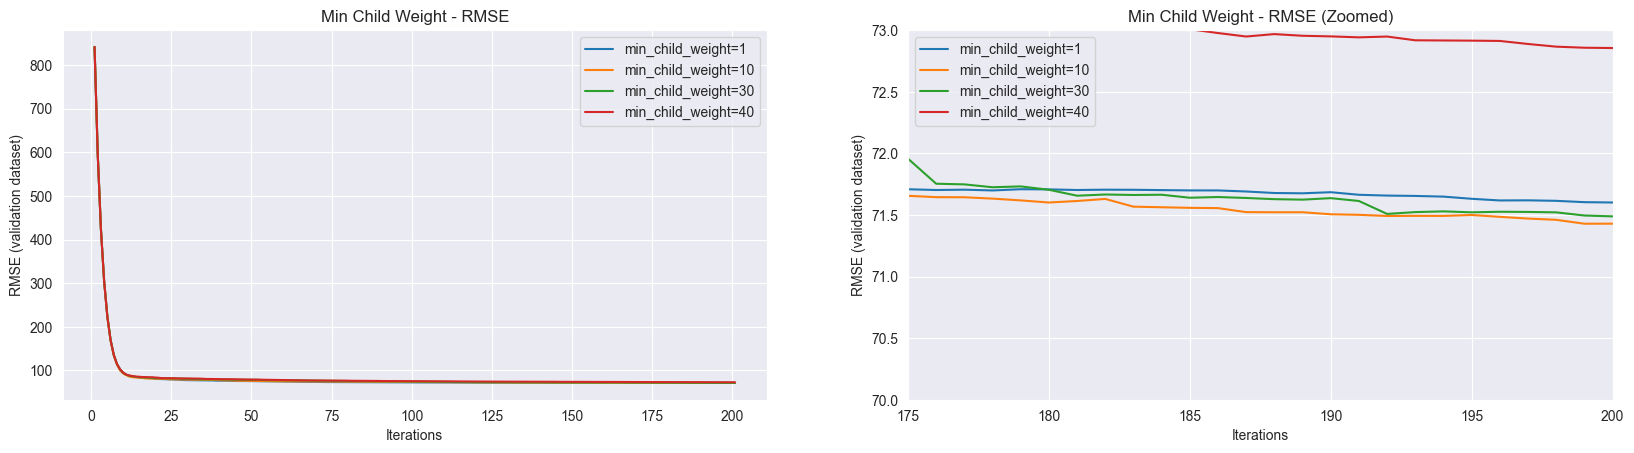

In [95]:
fig, axs = plt.subplots(1, 2)

fig.set_figwidth(20)

axs[0].set_title('Min Child Weight - RMSE')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('RMSE (validation dataset)')
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[0].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[0].legend()

axs[1].set_title('Min Child Weight - RMSE (Zoomed)')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('RMSE (validation dataset)')
axs[1].set_xlim([175, 200])
axs[1].set_ylim([70, 73])
for min_child_weight, df in scores.items():
    df = scores[min_child_weight]
    axs[1].plot(df.iter, df.val_rmse, label=min_child_weight)
    axs[1].legend()

In [96]:
# The above analysis shows min_child_weight=30 gives the best performance.
chosen_min_child_weight = 30

### Final GB model and its Performance

In [97]:
# training with full_train and chosen params, df_test as the validation set. Measure the performance.
chosen_eta = 0.3
chosen_max_depth = 10
chosen_min_child_weight = 30

full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)
dm_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)

(model, scores) = train_gb_model(dm_train=dm_full_train,
                                 eta=chosen_eta,
                                 max_depth=chosen_max_depth,
                                 min_child_weight=chosen_min_child_weight,
                                 num_boost_round=201,
                                 watchlist=[(dm_full_train, 'train'), (dm_test, 'val')])

gb_rmse = scores.sort_values(by='val_rmse').iloc[0, 3]
f'rmse of xgb model on full_train set = {gb_rmse}'

'rmse of xgb model on full_train set = 65.20070797072874'

<BarContainer object of 19 artists>

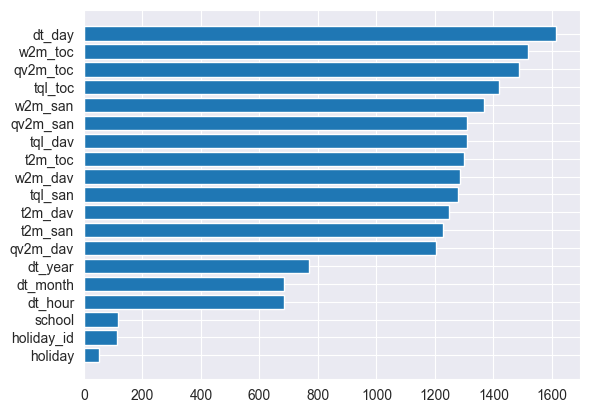

In [98]:
df_ft_imp = pd.DataFrame.from_dict(
    model.get_score(importance_type='weight'), orient='index').sort_values(by=0, ascending=True)
df_ft_imp.columns = ['score']
plt.barh(df_ft_imp.index, df_ft_imp.score)

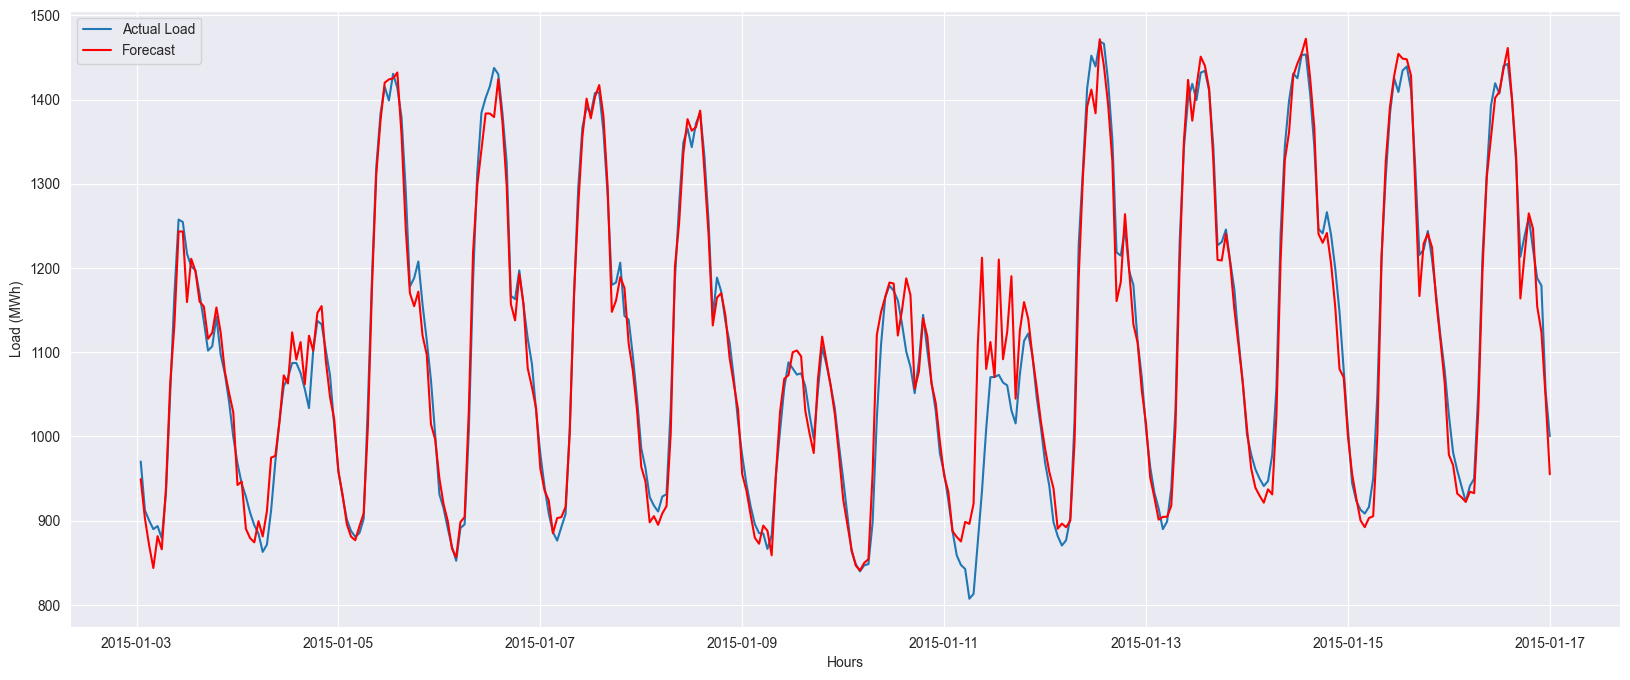

In [99]:
# Plot using the df_full_train and y_full_train to see how closely the forecasted demand tracks against the actual demand.
# Why am I using df_full here? To plot the forecast and actual, I need the data in the correct order. Because the load/demand
# is recorded hourly and continuously. In the other dataframes the data is shuffled therefore not suitable for plotting.
full_dicts = df_full.to_dict(orient='records')
X_full = dv.transform(full_dicts)
dm_full = xgb.DMatrix(X_full, label=y_full, feature_names=features)

y_full_pred = model.predict(dm_full)

plt.figure(figsize=(20, 8))
load_period = 24 * 14
actual = y_full[:load_period]
predict = y_full_pred[:load_period]

plt.plot(actual.index, list(actual), label='Actual Load')
plt.plot(actual.index, list(predict), color='red', label='Forecast')
plt.xlabel('Hours')
plt.ylabel('Load (MWh)')
plt.legend()

Plotting the prediction error distribution. The plot depicts a normal distribution for the prediction error of the best performing model. This confirms the following about the input dataset used for training the model (see [source](https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd)):
* The dependent or independent variables are not too non-normal.
* No outliers exist in the features which disrupt the model prediction.

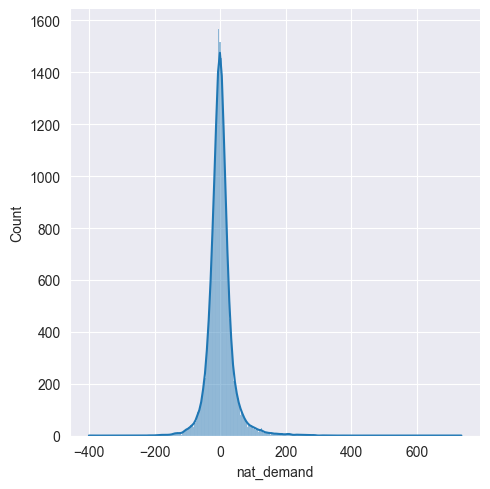

In [100]:
error = y_full_pred - y_full
sns.displot(error, kde=True)

# Export Model
Exporting the model using bentoml to serve as an online service.

In [101]:
#  NOTE: Ths is now moved to train.py

# import bentoml
#
# # retraining without the feature_names in the dmatrix, as otherwise predict() will fail later in the pipeline.
# dm_full_train = xgb.DMatrix(X_full_train, label=y_full_train)
# (model, scores) = train_gb_model(dm_train=dm_full_train,
#                                  eta=chosen_eta,
#                                  max_depth=chosen_max_depth,
#                                  min_child_weight=chosen_min_child_weight,
#                                  num_boost_round=201,
#                                  watchlist=None)
# bentoml.xgboost.save_model("load_forecast_model", model,
#                            custom_objects={
#                                "dictVectorizer": dv
#                            },
#                            signatures={
#                                "predict": {
#                                    "batchable": True,
#                                    "batch_dim": 0
#                                }
#                            })

# Export Test Data for the Dashboard
This exports the test dataframe as a json file to feed into the load forecast dashboard. See dashboard.py for the app and/or see the details in the README.md.

A test request payload i.e. `dict(df_test.iloc[0])` for adhoc testing

```json
{
  "t2m_toc": 25.6113220214844,
  "qv2m_toc": 0.01747758,
  "tql_toc": 0.043762207,
  "w2m_toc": 15.885400482402956,
  "t2m_san": 23.8613220214844,
  "qv2m_san": 0.016439982,
  "tql_san": 0.03894043,
  "w2m_san": 6.2321456709303815,
  "t2m_dav": 22.9472595214844,
  "qv2m_dav": 0.01531083,
  "tql_dav": 0.062301636,
  "w2m_dav": 3.6011136954933645,
  "holiday_id": 0.0,
  "holiday": 0.0,
  "school": 0.0,
  "dt_year": 2019.0,
  "dt_month": 1.0,
  "dt_day": 8.0,
  "dt_hour": 20.0
}
```

In [104]:
df_json = df_full[-1100:]
df_json['nat_demand'] = y_full[-1100:]
json_test = df_json.to_json(orient='table', index=True)
parsed_json = json.loads(json_test)

/var/folders/3k/wpbmfx3d5_l7cm4gbhbxtnk80000gp/T/ipykernel_46351/3311357979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_json['nat_demand'] = y_full[-1100:]


In [108]:
with open("dashboard/test_input.json", 'w') as f_out:
    json.dump(parsed_json['data'], f_out)